## Portfolio optimization
This example illustrates portfolio optimization technique based on the modern portfolio theory concept of efficient frontier introduced by Harry Markowitz in 1952. An investment portfolio belongs to the efficient frontier if it offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. In this example we consider a portfolio of 6 large cap US stocks and we will optimize the portfolio, i.e. calculate the amount of each stock we need to hold in our portfolio to bring the portfolio to the efficient frontier.
In this example we're utilizing a bunch of useful Python libraries including a library of financial functions named "ffn" and portfolio optimization library named "PyPortfolioOpt" in addition to popular numpy, matplotlib and pandas libraries.

In [1]:
import ffn
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import eikon as ek
# replace the code below with ek.set_app_key(EIKON_APP_KEY) call using app key generated by you
import os
EIKON_APP_KEY = os.environ.get('EIKON_APP_KEY')
if EIKON_APP_KEY==None:
    print('App key is needed to retrieve data from Eikon. Generate your app key and use it in ek.set_app_key call.')
else:
    ek.set_app_key(EIKON_APP_KEY) 

## Retrieving stock prices and rebasing to view price performance on common scale

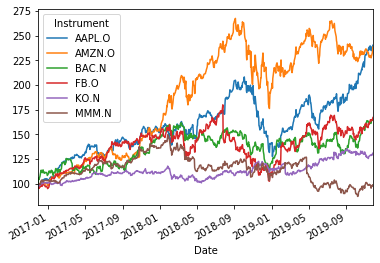

In [2]:
stocks_list = ['KO.N','AAPL.O','AMZN.O','FB.O','BAC.N','MMM.N']
def get_prices(stocks, start_date):
    stock_prices, err = ek.get_data(stocks,
                         ['TR.PriceClose.date','TR.PriceClose'],
                         {'SDate':start_date, 'EDate':'0D'})
    stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
    stock_prices = stock_prices.set_index(['Date','Instrument'])
    stock_prices = stock_prices.unstack()
    stock_prices.columns = stock_prices.columns.get_level_values(1)
    return stock_prices
prices = get_prices(stocks_list, start_date='-3Y')
ax = prices.rebase().plot()

## Calculating stats
Once stock prices are retrieved we can display a bunch of stats for each stock including Sharpe and Sortino ratios.

In [3]:
np.seterr(all='ignore')
stats = prices.calc_stats()
stats.display()

Stat                 AAPL.O      AMZN.O      BAC.N       FB.O        KO.N        MMM.N
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2016-11-29  2016-11-29  2016-11-29  2016-11-29  2016-11-29  2016-11-29
End                  2019-11-27  2019-11-27  2019-11-27  2019-11-27  2019-11-27  2019-11-27
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         140.30%     138.49%     64.71%      67.12%      31.11%      -1.25%
Daily Sharpe         1.31        1.20        0.83        0.74        0.70        0.09
Daily Sortino        2.14        2.00        1.38        1.11        1.09        0.12
CAGR                 34.04%      33.70%      18.15%      18.72%      9.47%       -0.42%
Max Drawdown         -38.73%     -34.10%     -30.79%     -42.96%     -14.38%     -41.72%
Calmar Ratio         0.88        0.99        0.59        0.44        0.66        -0.01

MTD                  7.6

## Initial portfolio
Next we consider an initial portfolio with randomly assigned weights for each stock and calculate expected return and volatility of this portfolio.

In [4]:
# portfolio weights
weights = np.asarray([0.4,0.2,0.1,0.1,0.1,0.1])

returns = prices.pct_change()
 
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

# portfolio return and volatility
pf_return = round(np.sum(mean_daily_returns * weights) * 252, 3)
pf_std_dev = round(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252), 3)

print("Expected annualized return: " + "{:.1%}".format(pf_return))
print("Volatility: " + "{:.1%}".format(pf_std_dev))

Expected annualized return: 24.8%
Volatility: 18.3%


## Optimized portfolio
Now let's calculate portfolio weights that maximize Sharpe ratio and compare the return and volatility of this portfolio to our initial portfolio.

In [5]:
# Expected returns and sample covariance
exp_returns = expected_returns.mean_historical_return(prices)
covar = risk_models.sample_cov(prices)

# Optimise portfolio for maximum Sharpe Ratio
ef = EfficientFrontier(exp_returns, covar)
raw_weights = ef.max_sharpe()
pf = ef.clean_weights()
print(pf)
perf = ef.portfolio_performance(verbose=True)

{'AAPL.O': 0.38866, 'AMZN.O': 0.2362, 'BAC.N': 0.09652, 'FB.O': 0.0, 'KO.N': 0.27862, 'MMM.N': 0.0}
Expected annual return: 25.0%
Annual volatility: 16.8%
Sharpe Ratio: 1.37


## Short selling
You see that in the previous step two stocks were removed from our portfolio. What if we allow short positions in our portfolio and optimize it by minimizing risk for a given target return?

In [6]:
ef = EfficientFrontier(exp_returns, covar, weight_bounds=(-1, 1))
pf = ef.efficient_return(target_return=perf[0])
print(pf)
perf = ef.portfolio_performance(verbose=True)

{'AAPL.O': 0.303965600580418, 'AMZN.O': 0.1776183858965163, 'BAC.N': 0.20777261447797482, 'FB.O': -0.011781001328141041, 'KO.N': 0.6027146347675877, 'MMM.N': -0.2802902343943557}
Expected annual return: 25.0%
Annual volatility: 15.1%
Sharpe Ratio: 1.53


Comparing the result with our long only portfolio for the same return we see slightly lower risk and higher Sharpe ratio.

## Discrete allocation
The weights calculated for our optimized portfolio don't tell us how much of each stock we should hold. They may also result in fractional numbers of stocks, which is impractical. In the next step we use integer programming method to create discrete allocations for our portfolio. In other words given the cash amount we have to invest we calculate integer number for each stock holding and the amount of leftover cash.

In [7]:
latest_prices = discrete_allocation.get_latest_prices(prices)
allocation, leftover = discrete_allocation.DiscreteAllocation(pf, latest_prices, 
                                                              total_portfolio_value=100000).lp_portfolio()
print(allocation)
print("Funds remaining: ${:.2f}".format(leftover))

0 out of 6 tickers were removed

Allocating long sub-portfolio:
0 out of 4 tickers were removed

Allocating short sub-portfolio:
0 out of 2 tickers were removed
{'AAPL.O': 87, 'AMZN.O': 8, 'BAC.N': 481, 'KO.N': 854, 'FB.O': -6, 'MMM.N': -168}
Funds remaining: $127.04


## Efficient frontier chart for this portfolio

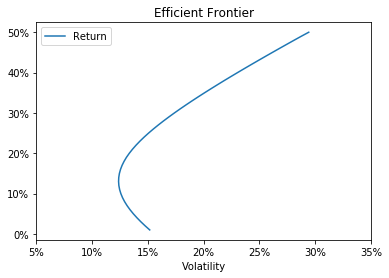

In [8]:
def risk_return(row):
    pf = ef.efficient_return(target_return=row.Target_Return)
    perf = ef.portfolio_performance()
    row.Return = perf[0]
    row.Volatility = perf[1]
    return row
df = pd.DataFrame(columns=['Target_Return','Volatility','Return'])
df['Target_Return'] = np.linspace(0.01, 0.5)
df = df.apply(risk_return, axis=1)
ax = df.plot(x='Volatility', y='Return', xlim = (0.05, 0.35), title='Efficient Frontier')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))